In [1]:
import numpy as np
import pylab as pl

from pacholcsyk import *
import freefree as ff

To start with we can define a few parameters of the galaxy. 

- We'll model it as a solid disk with height 1kpc and a radius of 15kpc. 

- We'll assume a galactic magnetic field strength of 6 $\mu$G.

- We'll assume a thermal electron density of 0.01 cm$^{-3}$

- We'll assume a thermal electron temperature of $3\times 10^5$ K.

In [2]:
gal_radius_kpc = 15.
gal_height_kpc = 1.
H_G = 6e-6				# [G] = 6 uGauss  [CGS units]
H_T = H_G*1e-4          # T  [SI units]
ne_cm = 0.01			# cm^-3	[CGS units]
Te = 3e5				# [K]
N0 = 5e-10				# what should this be..? [m^-3 MeV^-1]

pc2cm = 3.086e18

In [3]:
nu = 10**np.arange(3,12,0.1)  # 1 kHz -> 10 GHz

In [4]:
em_nu = calc_em_synch(nu,H_G,N0)

integrals.py:15: RuntimeWarning: divide by zero encountered in log
  return quad(lambda x,*args: np.exp(x + np.log(func(np.exp(x),*args))), np.log(a), np.log(b), **kwargs)


In [5]:
kappa_nu = calc_kappa_synch(nu,H_G,N0)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [6]:
kappa_ff = ff.calc_kappa_ff(nu,ne_cm,Te)/pc2cm  # cm^-1

In [7]:
kappa = kappa_ff+kappa_nu

In [8]:
dl = 1.61*gal_height_kpc*1000.*pc2cm
tau_nu = kappa_nu*dl
tau_ff = kappa_ff*dl
tau = kappa*dl

In [9]:
i_nu = (em_nu/kappa)*(1 - np.exp(-1.*tau))

We're going to compare with Longair's approximation. This is calculated in SI units:

In [10]:
dr = gal_radius_kpc*1000.*pc2cm/100. # metres [SI units]
A_m2 = np.pi*dr**2

L_abs = L_abs_ML(nu, H_T, A_m2)
L_nu = i_nu*1e-3*4*np.pi*A_m2	# 1e-3 for conversion: erg/s/cm^2/Hz ---> Watts/m^2/Hz

Let's plot that up:

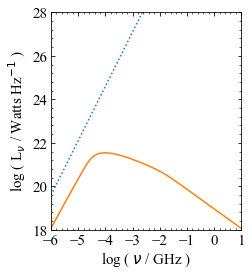

In [11]:
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rcParams

rcParams['font.sans-serif'] = "Times New Roman"
rcParams['font.family'] = "sans-serif"

ax = pl.subplot(111)

pl.plot(np.log10(nu/1e9), np.log10(L_abs), ls=":")
pl.plot(np.log10(nu/1e9), np.log10(L_nu)) 

pl.axis([-6,1,18,28])
pl.xlabel(r"log ( $\nu$ / GHz )",size=15)
pl.ylabel(r"log ( L$_{\nu}$ / Watts Hz$^{-1}$ )",size=15)
pl.locator_params(axis='x', nbins=8)
pl.locator_params(axis='y', nbins=5)
ax.tick_params(which="both",direction="in",top=True,right=True,labelsize=15)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_aspect(0.8)

rcParams['figure.figsize'] = [10, 10]
pl.show()

To make the Fig 1(b) plot we need to loop:

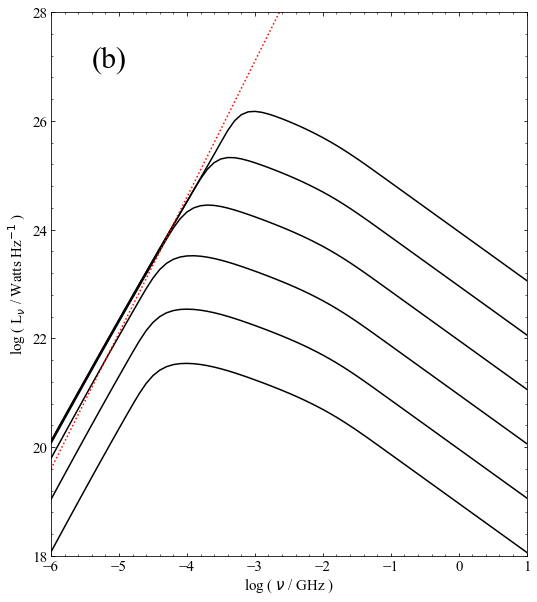

In [12]:
ax = pl.subplot(111)

em_nu0 = calc_em_synch(nu,H_G,N0)
kappa_nu0 = calc_kappa_synch(nu,H_G,N0)
    
for i in range(-10,-4):
    
    N1 = 5.*10.**(i)
    
    em_nu = em_nu0*N1/N0
    kappa_nu = kappa_nu0*N1/N0
    
    kappa = kappa_nu+kappa_ff
    tau_nu = kappa*dl
    i_nu = (em_nu/kappa)*(1 - np.exp(-1.*tau_nu))
    L_nu = i_nu*1e-3*4*np.pi*A_m2   # 1e-3 for: erg/s/cm^2/Hz --> Watts/m^2/Hz

    x = np.log10(nu[np.where(L_nu>0.)]/1e9)
    y = np.log10(L_nu[np.where(L_nu>0.)])
    pl.plot(x,y,c='black')
    
pl.plot(np.log10(nu/1e9), np.log10(L_abs), c='r', ls=":")

pl.axis([-6,1,18,28])
pl.xlabel(r"log ( $\nu$ / GHz )",size=15)
pl.ylabel(r"log ( L$_{\nu}$ / Watts Hz$^{-1}$ )",size=15)
pl.locator_params(axis='x', nbins=8)
pl.locator_params(axis='y', nbins=5)
ax.tick_params(which="both",direction="in",top=True,right=True,labelsize=15)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_aspect(0.8)

pl.text(-5.4,27,"(b)",size=30)

rcParams['figure.figsize'] = [10, 10]
pl.show()